In [1]:
import os
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown
import time

Global seed set to 0
/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/pytorch_lightning/utilities/warnings.py:54: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  "pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6"
/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [3]:
st = time.time()

In [4]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [5]:
# url = 'https://drive.google.com/uc?id=1Vh6RpYkusbGIZQC8GMFe3OKVDk5PWEpC'
# output = 'pbmc.h5ad'
# gdown.download(url, output, quiet=False)

In [6]:
adata = sc.read('pbmc.h5ad')
# adata = sc.pp.subsample(adata, fraction=None, n_obs=5000, random_state=0, copy=True)

In [7]:
adata.X = adata.layers["counts"].copy()

In [8]:
condition_key = 'batch'
target_conditions = ['10X']

trvae_epochs = 500
surgery_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

In [9]:
target_conditions = ["10X"]
removed_dataset = ['10X', 'Villani']
source_adata = adata[~adata.obs.study.isin(removed_dataset)].copy()
target_adata = adata[adata.obs.study.isin(target_conditions)].copy()
source_conditions = source_adata.obs[condition_key].unique().tolist()
print(source_adata)
print(target_adata)

AnnData object with n_obs × n_vars = 21757 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'
AnnData object with n_obs × n_vars = 10727 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'


In [10]:
source_adata.raw = source_adata

In [11]:
source_adata

AnnData object with n_obs × n_vars = 21757 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

In [12]:
sc.pp.normalize_total(source_adata)

In [13]:
sc.pp.log1p(source_adata)

In [14]:
sc.pp.highly_variable_genes(
    source_adata,
    n_top_genes=2000,
    batch_key="batch",
    subset=True)

/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [15]:
source_adata.X = source_adata.raw[:, source_adata.var_names].X

In [16]:
source_adata

AnnData object with n_obs × n_vars = 21757 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [17]:
trvae = sca.models.TRVAE(
    adata=source_adata,
    condition_key=condition_key,
    conditions=source_conditions,
    hidden_layer_sizes=[128, 128],
)


INITIALIZING NEW NETWORK..............
	Input Layer in, out and cond: 2000 128 8
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 8
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 2000 



In [18]:
trvae.train(
    n_epochs=trvae_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    learning_approach='Surgery',
)

Surgery is happening!
 |██████--------------| 30.6%  - val_loss: 676.9334393670 - val_recon_loss: 636.9863317153 - val_kl_loss: 13.7369467230 - val_mmd_loss: 29.5070212869
ADJUSTED LR
 |█████████-----------| 47.2%  - val_loss: 677.3675465303 - val_recon_loss: 635.7853106330 - val_kl_loss: 11.0978893953 - val_mmd_loss: 30.4843494191
ADJUSTED LR
 |█████████-----------| 48.6%  - val_loss: 678.2778751149 - val_recon_loss: 635.4653822955 - val_kl_loss: 11.3911494648 - val_mmd_loss: 31.4213316300
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 221


In [19]:
adata_latent = sc.AnnData(trvae.get_latent())
adata_latent.obs["cell_type"] = source_adata.obs["final_annotation"].tolist()
adata_latent.obs["batch"] = source_adata.obs["batch"].tolist()

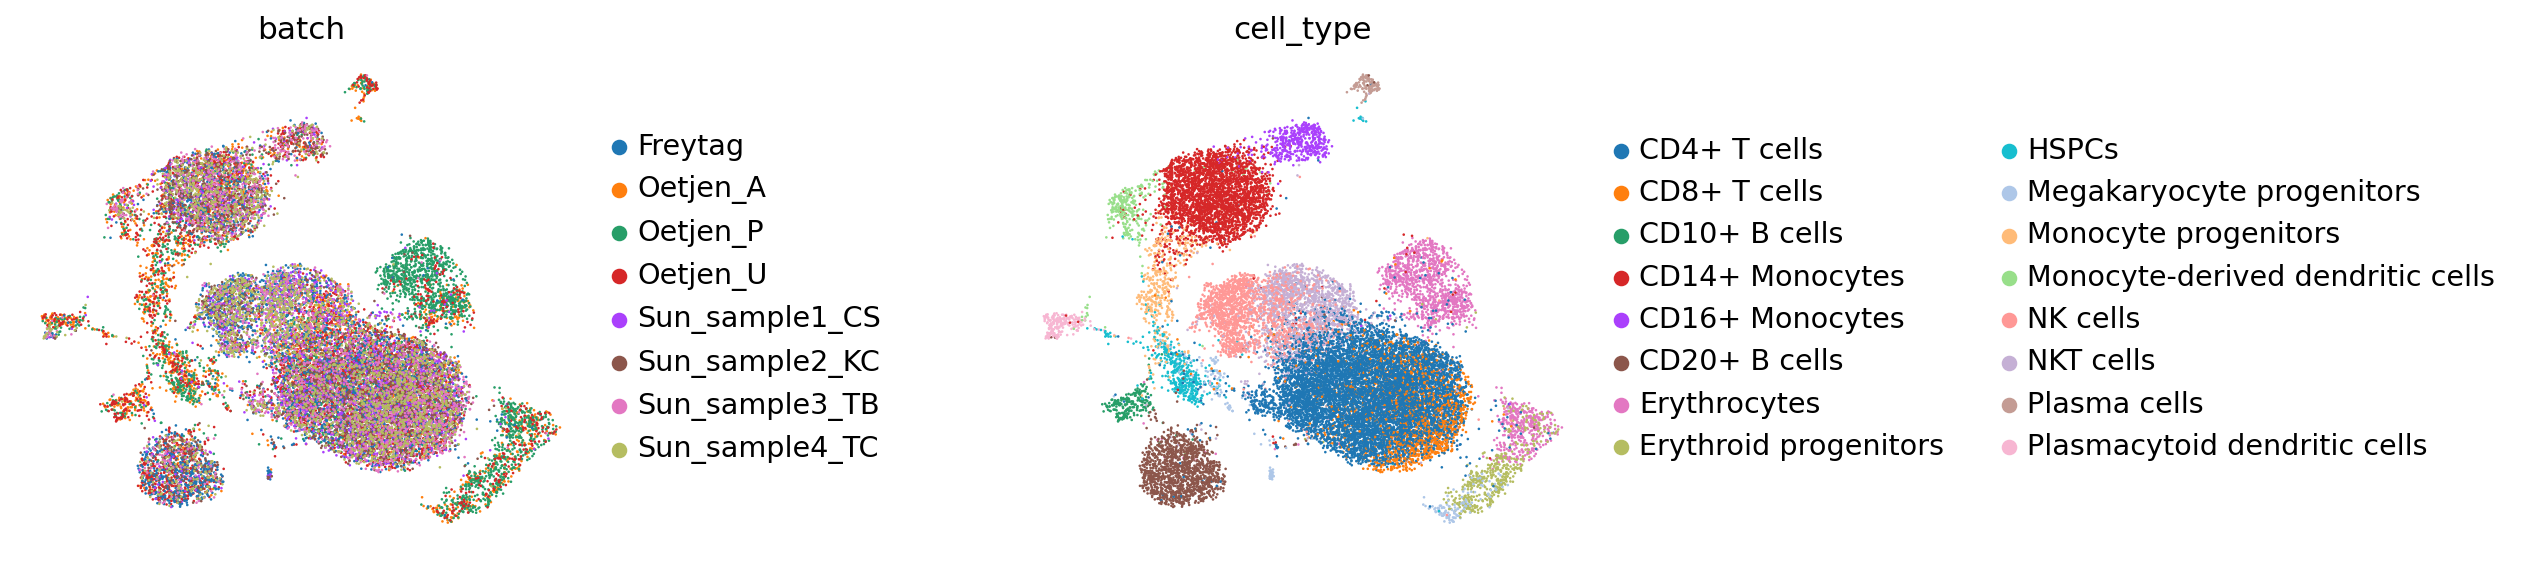

In [20]:
sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [21]:
ref_path = 'reference_model_PBMC/'
trvae.save(ref_path, overwrite=True)

In [22]:
target_adata

AnnData object with n_obs × n_vars = 10727 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

In [23]:
target_adata = target_adata[:, source_adata.var_names]
target_adata

View of AnnData object with n_obs × n_vars = 10727 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

In [24]:
new_trvae = sca.models.TRVAE.load_query_data(adata=target_adata, learning_approach = 'Surgery', model=ref_path)


INITIALIZING NEW NETWORK..............
	Input Layer in, out and cond: 2000 128 9
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 9
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 2000 



In [25]:
new_trvae.train(
    n_epochs=surgery_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    weight_decay=0,
    learning_approach='Surgery',
)

Surgery is happening!
 |██------------------| 12.8%  - val_loss: 1080.6653713650 - val_recon_loss: 1075.4699842665 - val_kl_loss: 16.4932791392 - val_mmd_loss: 0.0000000000
ADJUSTED LR
 |███-----------------| 19.2%  - val_loss: 1082.1963433160 - val_recon_loss: 1074.5389675564 - val_kl_loss: 16.1207616594 - val_mmd_loss: 0.0000000000
ADJUSTED LR
 |████----------------| 20.6%  - val_loss: 1074.8065524631 - val_recon_loss: 1066.6005927192 - val_kl_loss: 16.0901133219 - val_mmd_loss: 0.0000000000
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 81


In [26]:
adata_latent = sc.AnnData(new_trvae.get_latent())
adata_latent.obs['cell_type'] = target_adata.obs["final_annotation"].tolist()
adata_latent.obs['batch'] = target_adata.obs["batch"].tolist()

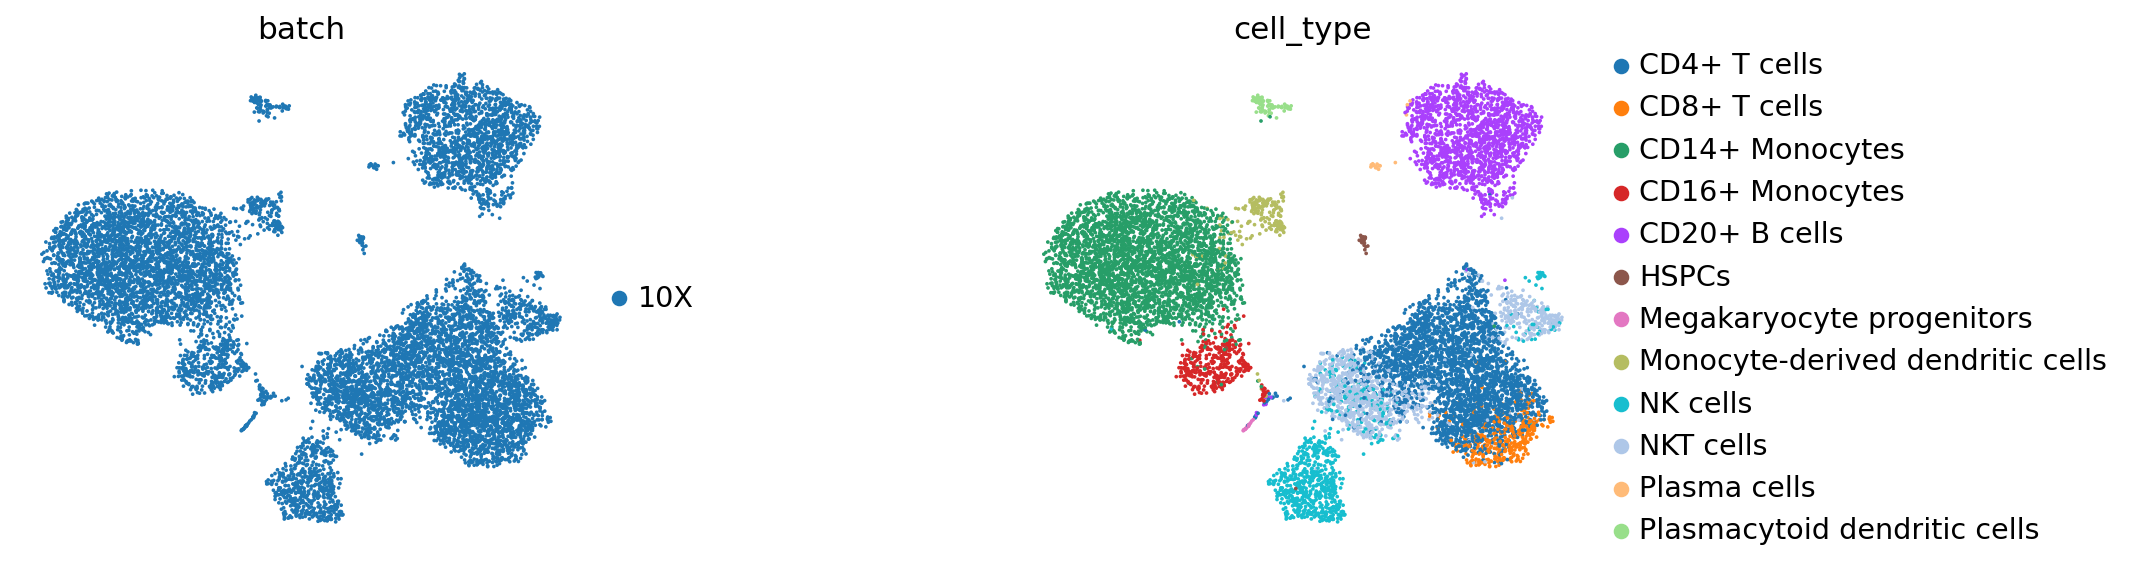

In [27]:
sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [28]:
surg_path = 'surgery_model_PBMC'
new_trvae.save(surg_path, overwrite=True)

In [29]:
adata_full = source_adata.concatenate(target_adata, batch_key="ref_query")
adata_full

AnnData object with n_obs × n_vars = 32484 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'trvae_size_factors', 'trvae_labeled', 'ref_query'
    var: 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable_nbatches-0', 'highly_variable_intersection-0'
    layers: 'counts'

In [30]:
full_latent = sc.AnnData(new_trvae.get_latent(adata_full.X, adata_full.obs[condition_key]))
full_latent.obs['cell_type'] = adata_full.obs["final_annotation"].tolist()
full_latent.obs['batch'] = adata_full.obs["batch"].tolist()

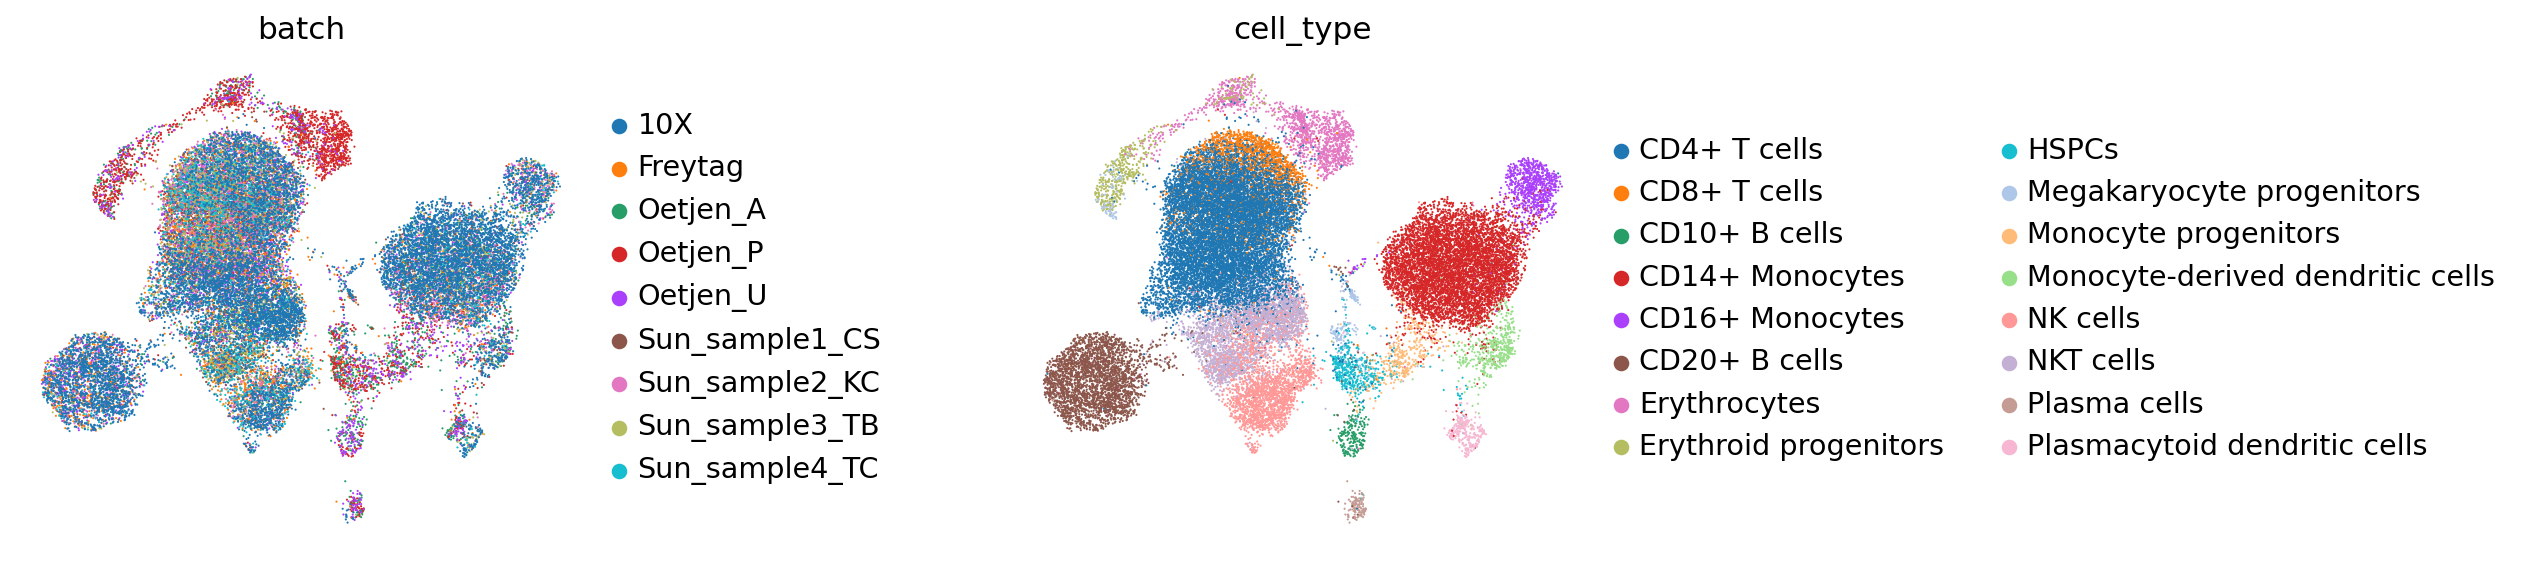

In [31]:
sc.pp.neighbors(full_latent, n_neighbors=8)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)
sc.pl.umap(full_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [32]:
elapsed_time = time.time() - st
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time: 00:44:39


In [33]:
# !pip install scib

In [34]:
import scanpy
import scib
arches_nb_graph=sc.pp.neighbors(full_latent, n_neighbors=8, n_pcs=None, use_rep='X')
Batch_corr_graph_conn_rehearsal=scib.metrics.graph_connectivity(full_latent, 'batch')
Batch_corr_graph_conn_surgery 

0.37822842278473234

In [35]:
sc.tl.umap(full_latent)
Batch_corr_ASW_rehearsal=scib.metrics.silhouette_batch(full_latent, batch_key='batch', group_key='cell_type', embed='X_umap')
Batch_corr_ASW_surgery

mean silhouette per group:                                   silhouette_score
group                                             
CD10+ B cells                             0.824515
CD14+ Monocytes                           0.902507
CD16+ Monocytes                           0.744625
CD20+ B cells                             0.813446
CD4+ T cells                              0.790354
CD8+ T cells                              0.802364
Erythrocytes                              0.760711
Erythroid progenitors                     0.808927
HSPCs                                     0.696107
Megakaryocyte progenitors                 0.541356
Monocyte progenitors                      0.808785
Monocyte-derived dendritic cells          0.715471
NK cells                                  0.791880
NKT cells                                 0.763695
Plasma cells                              0.671602
Plasmacytoid dendritic cells              0.785223


0.7638480643383867

In [36]:
Bio_cons_ASW_rehearsal=scib.metrics.silhouette(full_latent, group_key='cell_type', embed='X_umap')
Bio_cons_ASW_surgery

0.5941552445292473

In [37]:
isolated_labels_rehearsal=scib.metrics.isolated_labels(full_latent, label_key='cell_type', batch_key='batch', embed='X_umap')
isolated_labels_surgery

isolated labels: no more than 3 batches per label


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


CD10+ B cells: 0.9206349206349208


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Erythrocytes: 0.7905718701700155


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Erythroid progenitors: 0.6925373134328359


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Monocyte progenitors: 0.7222857142857142


0.7815074546308716

In [38]:
pcr_justone=scib.metrics.pcr_comparison(source_adata, adata, covariate='batch', embed=None, n_comps=50, scale=False, verbose=False)
pcr_surgery

0.3796990561328954

In [3]:
Batch_corr_graph_conn_surgery= 0.37822842278473234
# Batch_corr_graph_conn_onetenth=0.9048741734427915
# Batch_corr_graph_conn_onefourth= 0.899889876263836
# Batch_corr_graph_conn_oneseven=0.900851122200876
Batch_corr_graph_conn_justone= 0.7669875695216818
# Batch_corr_graph_conn_rehearsal= 
Batch_corr_graph_conn_LR_1= 0.5849331122572639
Batch_corr_graph_conn_LR_1_EWC_1= 0.4808110983989145
Batch_corr_graph_conn_std = 0.3603788592508095

Batch_corr_ASW_surgery= 0.7638480643383867
# Batch_corr_ASW_onetenth=0.7700163313882914
# Batch_corr_ASW_onefourth= 0.7647092329403207
# Batch_corr_ASW_oneseven=0.7677420977118364
Batch_corr_ASW_justone= 0.7902545842983109
# Batch_corr_ASW_rehearsal=
Batch_corr_ASW_LR_1= 0.8003258490275433
Batch_corr_ASW_LR_1_EWC_1= 0.820046794331812
Batch_corr_ASW_std= 0.7588972230375477

Bio_cons_ASW_surgery= 0.5941552445292473
# Bio_cons_ASW_onetenth=0.6302791982889175
# Bio_cons_ASW_onefourth=0.6720504760742188
# Bio_cons_ASW_oneseven=0.6242425590753555
Bio_cons_ASW_justone= 0.5867989808320999
# Bio_cons_ASW_rehearsal=
Bio_cons_ASW_LR_1= 0.4697665423154831
Bio_cons_ASW_LR_1_EWC_1= 0.48397761210799217
Bio_cons_ASW_std= 0.5903133973479271

isolated_labels_surgery= 0.7815074546308716
# isolated_labels_onetenth=0.8439304117951834
# isolated_labels_onefourth=0.8283473352451141
# isolated_labels_oneseven = 0.8430725908139767
isolated_labels_justone= 0.6871189861861209
# isolated_labels_rehearsal= 
isolated_labels_LR_1= 0.2592439673789017
isolated_labels_LR_1_EWC_1= 0.3843032662396856
isolated_labels_std= 0.8046993710615682

pcr_surgery = 0.3796990561328954
# pcr_onetenth = 0.02870146673652502
# pcr_onefourth=0.02870146673652502
# pcr_oneseven = 0.02870146673652502 
pcr_justone = 0.6530582954689051
# pcr_rehearsal = 
pcr_LR_1= 0.6530582954689051
pcr_LR_1_EWC_1= 0.6530582954689051
pcr_std = 0


import pandas as pd
methods_metrics = {'Surgery': [isolated_labels_surgery,Bio_cons_ASW_surgery,
                               Batch_corr_ASW_surgery, Batch_corr_graph_conn_surgery, pcr_surgery, 
                               (isolated_labels_surgery+Bio_cons_ASW_surgery+
                               Batch_corr_ASW_surgery+ Batch_corr_graph_conn_surgery+ pcr_surgery)/5], 
#                    'ewc_0.1': [isolated_labels_onetenth, Bio_cons_ASW_onetenth, 
#                                Batch_corr_ASW_onetenth, Batch_corr_graph_conn_onetenth,pcr_onetenth, 
#                                (isolated_labels_onetenth+ Bio_cons_ASW_onetenth+ 
#                                Batch_corr_ASW_onetenth+ Batch_corr_graph_conn_onetenth +pcr_onetenth)/5],
#                    'ewc_0.4': [isolated_labels_onefourth, Bio_cons_ASW_onefourth,
#                                Batch_corr_ASW_onefourth, Batch_corr_graph_conn_onefourth,pcr_onefourth, 
#                                (isolated_labels_onefourth+ Bio_cons_ASW_onefourth+
#                                Batch_corr_ASW_onefourth+ Batch_corr_graph_conn_onefourth+pcr_onefourth)/5], 
#                    'ewc_0.7':[isolated_labels_oneseven, Bio_cons_ASW_oneseven, 
#                               Batch_corr_ASW_oneseven, Batch_corr_graph_conn_oneseven, pcr_oneseven, 
#                               (isolated_labels_oneseven+ Bio_cons_ASW_oneseven+ 
#                               Batch_corr_ASW_oneseven+ Batch_corr_graph_conn_oneseven+ pcr_oneseven)/5],
                   'ewc_1': [isolated_labels_justone, Bio_cons_ASW_justone,
                               Batch_corr_ASW_justone, Batch_corr_graph_conn_justone, pcr_justone, 
                             (isolated_labels_justone+ Bio_cons_ASW_justone+
                               Batch_corr_ASW_justone+ Batch_corr_graph_conn_justone+ pcr_justone)/5], 
#                    'rehearsal': [isolated_labels_rehearsal, Bio_cons_ASW_rehearsal, 
#                                Batch_corr_ASW_rehearsal, Batch_corr_graph_conn_rehearsal, pcr_rehearsal,
#                              (isolated_labels_rehearsal+ Bio_cons_ASW_rehearsal+ 
#                                Batch_corr_ASW_rehearsal+ Batch_corr_graph_conn_rehearsal+ pcr_rehearsal)/5],
                  'Latent_replay_1.0':[isolated_labels_LR_1, Bio_cons_ASW_LR_1,
                               Batch_corr_ASW_LR_1, Batch_corr_graph_conn_LR_1, pcr_LR_1, 
                             (isolated_labels_LR_1+ Bio_cons_ASW_LR_1+
                               Batch_corr_ASW_LR_1+ Batch_corr_graph_conn_LR_1+ pcr_LR_1)/5],
                  'LR_1+EWC_1.0': [isolated_labels_LR_1_EWC_1, Bio_cons_ASW_LR_1_EWC_1, 
                               Batch_corr_ASW_LR_1_EWC_1, Batch_corr_graph_conn_LR_1_EWC_1, pcr_LR_1_EWC_1, 
                             (isolated_labels_LR_1_EWC_1+ Bio_cons_ASW_LR_1_EWC_1+ 
                               Batch_corr_ASW_LR_1_EWC_1+ Batch_corr_graph_conn_LR_1_EWC_1+ pcr_LR_1_EWC_1)/5],
                  'standard':[isolated_labels_std, Bio_cons_ASW_std, 
                               Batch_corr_ASW_std, Batch_corr_graph_conn_std, pcr_std, 
                             (isolated_labels_std+ Bio_cons_ASW_std+ 
                               Batch_corr_ASW_std+ Batch_corr_graph_conn_std+ pcr_std)/5]} 
index = ['isolated_labels','Bio_cons_ASW', 'Batch_corr_ASW','Batch_corr_graph_conn', 'pcr',  'overall'] #'approx_time_hrs',
methods_metrics_df = pd.DataFrame(data=methods_metrics, index=index)
methods_metrics_df

#time_LR_1_EWC_01,time_LR_1, time_rehearsal,time_justone,time_oneseven,time_onefourth,time_onetenth,time_surgery,

,Surgery,ewc_1,Latent_replay_1.0,LR_1+EWC_1.0,standard
isolated_labels,0.781507,0.687119,0.259244,0.384303,0.804699
Bio_cons_ASW,0.594155,0.586799,0.469767,0.483978,0.590313
Batch_corr_ASW,0.763848,0.790255,0.800326,0.820047,0.758897
Batch_corr_graph_conn,0.378228,0.766988,0.584933,0.480811,0.360379
pcr,0.379699,0.653058,0.653058,0.653058,0.000000
overall,0.579488,0.696844,0.553466,0.564439,0.502858


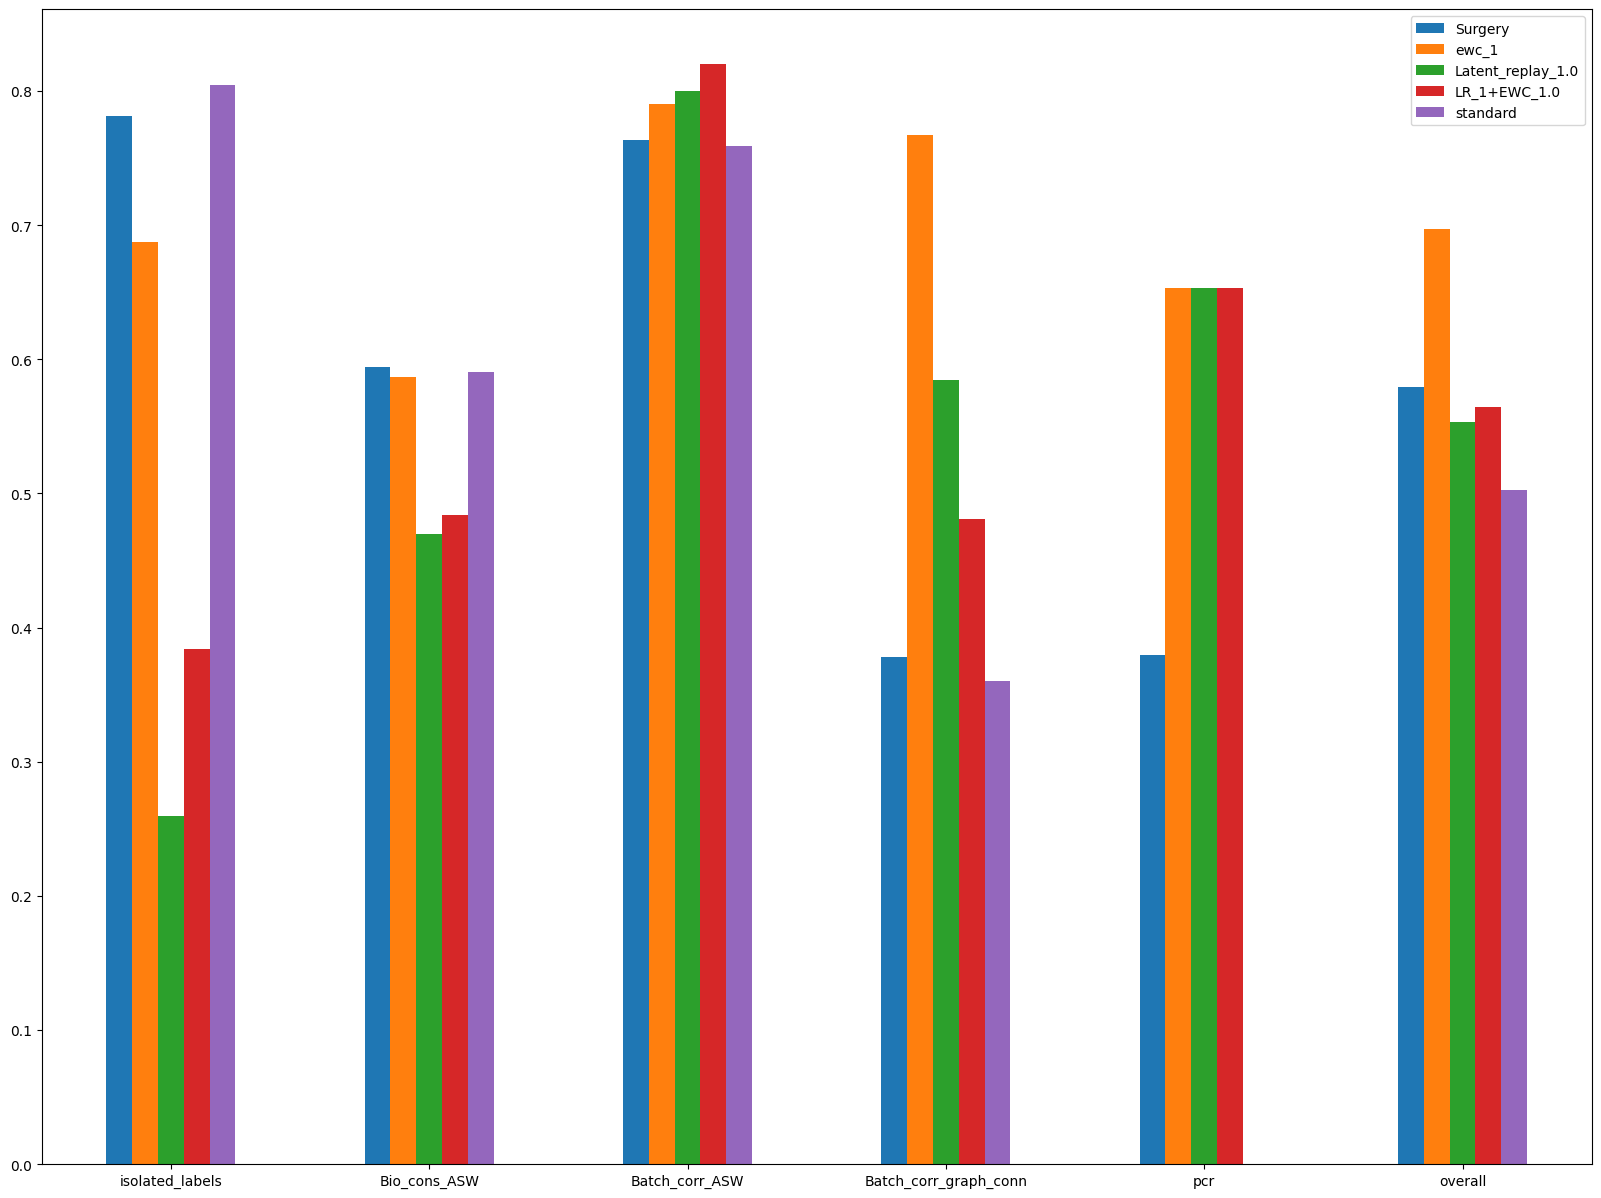

In [4]:
ax = methods_metrics_df.plot.bar(rot=0, figsize = (20,15))
# import matplotlib.pyplot as plt
# ax.axhline(y=1.5, color='r', linestyle='-')
# plt.show()

In [5]:
time_surgery = 0.75
# time_onetenth = 1 #00;58;16
# time_onefourth = 0.65 #00;39;46
# time_oneseven = 0.65 #00:41:08
time_justone = 0.6
# time_rehearsal = 0.65 #00;39;1
time_LR_1 = 3.45
time_LR_1_EWC_1 = 5
methods_metrics = {'Surgery': [time_surgery], 
#                    'ewc_0.1': [time_onetenth],
#                    'ewc_0.4': [time_onefourth], 
#                    'ewc_0.7':[time_oneseven],
                   'ewc_1': [time_justone], 
#                    'rehearsal': [time_rehearsal],
                  'Latent_replay_1.0':[time_LR_1],
                  'LR_10+EWC_1.0': [time_LR_1_EWC_1 ]} 
index = ['approx_time_hrs'] 
methods_metrics_df = pd.DataFrame(data=methods_metrics, index=index)
methods_metrics_df

,Surgery,ewc_1,Latent_replay_1.0,LR_10+EWC_1.0
approx_time_hrs,0.75,0.6,3.45,5


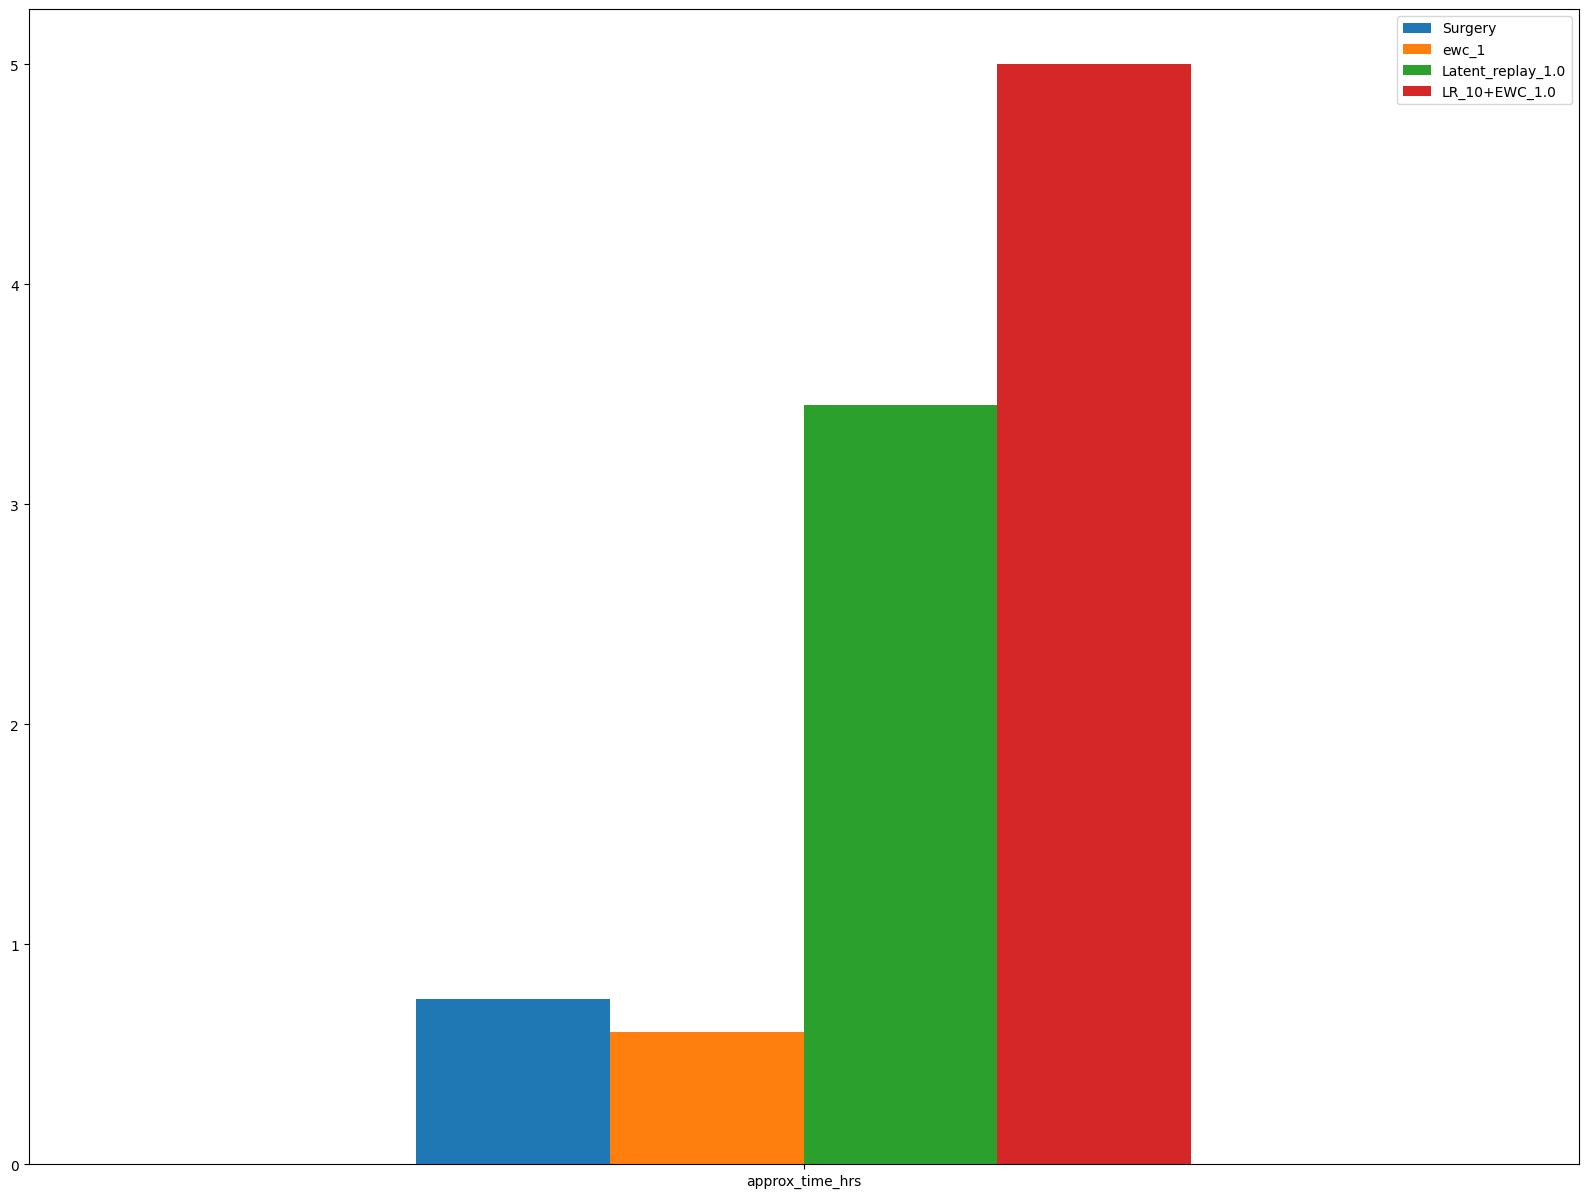

In [6]:
ax = methods_metrics_df.plot.bar(rot=0, figsize = (20,15))